In [1]:
import pylab
from pycbc.frame import read_frame
from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries as TS
import bilby
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters, generate_all_bbh_parameters
%matplotlib inline

merger = "GW170814"
gps = float(event_gps(merger))

print(bilby.__version__)

1.1.5: (CLEAN) 88cf7e2 2022-01-24 22:26:41 +0000


In [2]:
sampling_rate = 4096
duration = 4. # length of data in seconds
start_time = gps-duration/2

interferometers = bilby.gw.detector.InterferometerList([])

for ifo_name in ['L1', 'H1', 'V1']:
    ifo = bilby.gw.detector.get_empty_interferometer(ifo_name)
    ifo.set_strain_data_from_frame_file('data/'+merger+'_'+ifo_name+'_4KHZ.gwf', sampling_rate, duration, start_time=start_time, channel=ifo_name+':GWOSC-4KHZ_R1_STRAIN')
    ifo.maximum_frequency = 2048
    interferometers.append(ifo)

13:10 bilby INFO    : Reading data from frame file data/GW170814_L1_4KHZ.gwf
13:10 bilby INFO    : Successfully loaded L1:GWOSC-4KHZ_R1_STRAIN.
13:10 bilby INFO    : Reading data from frame file data/GW170814_H1_4KHZ.gwf
13:10 bilby INFO    : Successfully loaded H1:GWOSC-4KHZ_R1_STRAIN.
13:10 bilby INFO    : Reading data from frame file data/GW170814_V1_4KHZ.gwf
13:10 bilby INFO    : Successfully loaded V1:GWOSC-4KHZ_R1_STRAIN.


In [3]:
psd_alpha = 2 * interferometers[0].strain_data.roll_off / 4

L1_psd_data = TS.read('data/'+merger+'_L1_PSD.gwf', 'Strain')
L1_psd = L1_psd_data.psd(fftlength=4, overlap=0, window=("tukey", psd_alpha), method="median")
interferometers[0].power_spectral_density = bilby.gw.detector.PowerSpectralDensity(frequency_array=L1_psd.frequencies.value, psd_array=L1_psd.value)

H1_psd_data = TS.read('data/'+merger+'_H1_PSD.gwf', 'Strain')
H1_psd = H1_psd_data.psd(fftlength=4, overlap=0, window=("tukey", psd_alpha), method="median")
interferometers[1].power_spectral_density = bilby.gw.detector.PowerSpectralDensity(frequency_array=H1_psd.frequencies.value, psd_array=H1_psd.value)

V1_psd_data = TS.read('data/'+merger+'_V1_PSD.gwf', 'Strain')
V1_psd = V1_psd_data.psd(fftlength=4, overlap=0, window=("tukey", psd_alpha), method="median")
interferometers[2].power_spectral_density = bilby.gw.detector.PowerSpectralDensity(frequency_array=V1_psd.frequencies.value, psd_array=V1_psd.value)

In [4]:
prior = bilby.gw.prior.BBHPriorDict()

prior["geocent_time"] = bilby.core.prior.Uniform(gps-0.1, gps+0.1, name="geocent_time")

waveform_arguments = dict(waveform_approximant='IMRPhenomPv2', reference_frequency=100., catch_waveform_errors=True)
waveform_generator = bilby.gw.WaveformGenerator(
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    waveform_arguments=waveform_arguments,
    parameter_conversion=convert_to_lal_binary_black_hole_parameters)

likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers, waveform_generator, priors=prior,
    time_marginalization=True, phase_marginalization=False, distance_marginalization=True)

result_short = bilby.run_sampler(
    likelihood,
    prior,
    sampler='dynesty',
    outdir='short',
    label='GW170814',
    nlive=250,
    conversion_function=bilby.gw.conversion.generate_all_bbh_parameters
)

13:10 bilby INFO    : No prior given, using default BBH priors in /home/imcmahon/miniconda3/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.
13:10 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
13:10 bilby INFO    : Loaded distance marginalisation lookup table from .distance_marginalization_lookup.npz.
13:10 bilby INFO    : Running for label 'GW170814', output will be saved to 'short'
13:10 bilby INFO    : Using lal version 7.1.7
13:10 bilby INFO    : Using lal git version Branch: None;Tag: lal-v7.1.7;Id: c0930b69d9f2ad7151d1cadea5df72633ec47e67;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
13:10 bilby INFO    : Using lalsimulation version 3.1.2
13:10 bilby INFO    : Using lalsimulation git version B

0it [00:00, ?it/s]

13:10 bilby INFO    : Checkpoint every check_point_delta_t = 600s
13:10 bilby WARNING : Using cached result
13:10 bilby INFO    : Summary of results:
nsamples: 6305
ln_noise_evidence: -26241.281
ln_evidence: -26108.378 +/-  0.389
ln_bayes_factor: 132.902 +/-  0.389



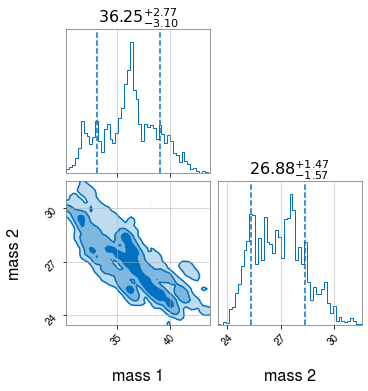

In [5]:
result_short.plot_corner(parameters=["mass_1", "mass_2"])

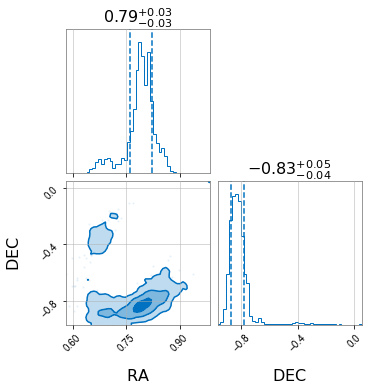

In [6]:
result_short.plot_corner(parameters=["ra", "dec"])

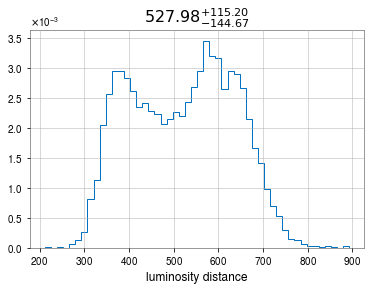

In [7]:
result_short.plot_corner(parameters=["luminosity_distance"])

In [8]:
prior = bilby.gw.prior.BBHPriorDict()

names = ['ra', 'dec']
mu = [[0.79, -0.83]]
cov = [[[0.03, 0.], [0., 0.04]]]
mvg = bilby.core.prior.MultivariateGaussianDist(names, mus=mu, covs=cov)

prior["ra"] = bilby.core.prior.Gaussian(name="ra", mu=0.79, sigma=0.03)
prior["dec"] = bilby.core.prior.Gaussian(name="dec", mu=-0.83, sigma=0.04)
prior["geocent_time"] = bilby.core.prior.Uniform(gps-0.1, gps+0.1, name="geocent_time")

waveform_arguments = dict(waveform_approximant='IMRPhenomPv2', reference_frequency=100., catch_waveform_errors=True)
waveform_generator = bilby.gw.WaveformGenerator(
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    waveform_arguments=waveform_arguments,
    parameter_conversion=convert_to_lal_binary_black_hole_parameters)

likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers, waveform_generator, priors=prior,
    time_marginalization=True, phase_marginalization=False, distance_marginalization=True)

result_short = bilby.run_sampler(
    likelihood,
    prior,
    sampler='dynesty',
    outdir='short',
    label='GW170814_single_mode',
    nlive=250,
    conversion_function=bilby.gw.conversion.generate_all_bbh_parameters
)

13:10 bilby INFO    : No prior given, using default BBH priors in /home/imcmahon/miniconda3/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.
13:10 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
13:10 bilby INFO    : Loaded distance marginalisation lookup table from .distance_marginalization_lookup.npz.
13:10 bilby INFO    : Running for label 'GW170814_single_mode', output will be saved to 'short'
13:10 bilby INFO    : Using lal version 7.1.7
13:10 bilby INFO    : Using lal git version Branch: None;Tag: lal-v7.1.7;Id: c0930b69d9f2ad7151d1cadea5df72633ec47e67;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
13:10 bilby INFO    : Using lalsimulation version 3.1.2
13:10 bilby INFO    : Using lalsimulation g

0it [00:00, ?it/s]

13:10 bilby INFO    : Checkpoint every check_point_delta_t = 600s
13:10 bilby WARNING : Using cached result
13:10 bilby INFO    : Summary of results:
nsamples: 4672
ln_noise_evidence: -26241.281
ln_evidence: -26100.001 +/-  0.313
ln_bayes_factor: 141.280 +/-  0.313



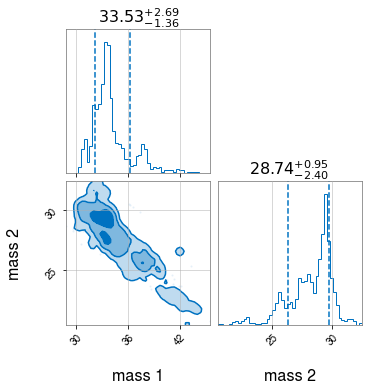

In [9]:
result_short.plot_corner(parameters=["mass_1", "mass_2"])

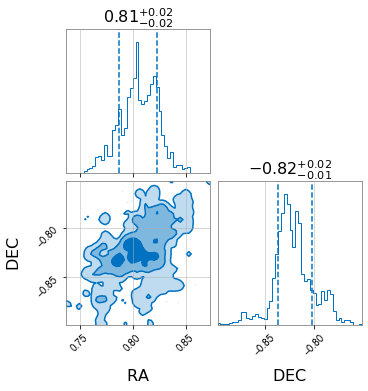

In [10]:
result_short.plot_corner(parameters=["ra", "dec"])

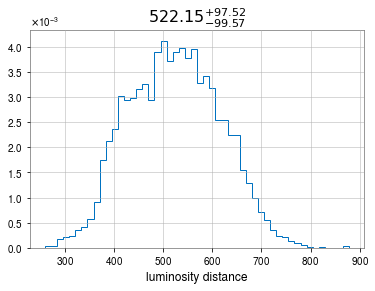

In [11]:
result_short.plot_corner(parameters=["luminosity_distance"])

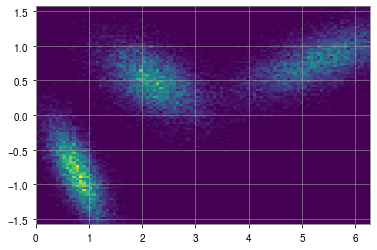

In [12]:
names = ['ra', 'dec']
mus = [[0.79, -0.83],
       [2.2, 0.5],
       [5.34, 0.8]
      ]
corrcoefs = [[[1.0, -0.7], [-0.7, 1.0]],
             [[1.0, -0.5], [-0.5, 1.0]],
             [[1.0, 0.7], [0.7, 1.0]]
            ]
sigmas = [[0.3, 0.4],
          [0.5, 0.3],
          [0.8, 0.3]
         ]
mvg = bilby.core.prior.MultivariateGaussianDist(names, mus=mus, corrcoefs=corrcoefs, sigmas=sigmas, nmodes=3)

sample1 = bilby.core.prior.MultivariateGaussian(mvg, 'ra').sample(30000)
sample2 = bilby.core.prior.MultivariateGaussian(mvg, 'dec').sample(30000)
plot = pylab.hist2d(sample1, sample2, bins=100, range=[[0,6.28],[-1.57,1.57]])

In [13]:
prior = bilby.gw.prior.BBHPriorDict()

names = ['ra', 'dec']
mu = [[0.79, -0.83]]
cov = [[[0.03, 0.], [0., 0.04]]]
mvg = bilby.core.prior.MultivariateGaussianDist(names, mus=mu, covs=cov)

prior["ra"] = bilby.core.prior.MultivariateGaussian(mvg, 'ra')
prior["dec"] = bilby.core.prior.MultivariateGaussian(mvg, 'dec')
prior["geocent_time"] = bilby.core.prior.Uniform(gps-0.1, gps+0.1, name="geocent_time")

waveform_arguments = dict(waveform_approximant='IMRPhenomPv2', reference_frequency=100., catch_waveform_errors=True)
waveform_generator = bilby.gw.WaveformGenerator(
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    waveform_arguments=waveform_arguments,
    parameter_conversion=convert_to_lal_binary_black_hole_parameters)

likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers, waveform_generator, priors=prior,
    time_marginalization=True, phase_marginalization=False, distance_marginalization=True)

13:10 bilby INFO    : No prior given, using default BBH priors in /home/imcmahon/miniconda3/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.
13:10 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
13:10 bilby INFO    : Loaded distance marginalisation lookup table from .distance_marginalization_lookup.npz.


In [14]:
result_short = bilby.run_sampler(
    likelihood,
    prior,
    sampler='dynesty',
    outdir='short',
    label='GW170814_sharp',
    nlive=250,
    conversion_function=bilby.gw.conversion.generate_all_bbh_parameters
)

13:10 bilby INFO    : Running for label 'GW170814_sharp', output will be saved to 'short'
13:10 bilby INFO    : Using lal version 7.1.7
13:10 bilby INFO    : Using lal git version Branch: None;Tag: lal-v7.1.7;Id: c0930b69d9f2ad7151d1cadea5df72633ec47e67;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
13:10 bilby INFO    : Using lalsimulation version 3.1.2
13:10 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsimulation-v3.1.2;Id: 8c3a6977aa553c9a2019ec287a61dc5ee92087b4;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
13:10 bilby INFO    : Search parameters:
13:10 bilby INFO    :   mass_ratio = Uniform(minimum=0.125, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None)
13:10 bilby INFO    :   chirp_mass = Uniform(minimum=25, maximum=100, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None)
13:10 bilby INFO    :   dec = Mul

0it [00:00, ?it/s]

13:10 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 250, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 150, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7fec400b2760>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5, 'print_method': 'tqdm'}
13:10 bilby INFO    : Checkpoint every check_point_delta_t = 600s
13:10 bilby INFO    : Using dynesty version 1.0.1
13:10 bilby INFO    : Using the bil

14:51 bilby INFO    : Sampling time: 1:40:28.809208
14:51 bilby INFO    : Reconstructing marginalised parameters.
14:51 bilby INFO    : Cached samples dict out of date, ignoring


  0%|          | 0/7505 [00:00<?, ?it/s]

14:53 bilby INFO    : Generating sky frame parameters.


  0%|          | 0/7505 [00:00<?, ?it/s]

14:53 bilby INFO    : Computing SNRs for every sample.


  0%|          | 0/7505 [00:00<?, ?it/s]

14:53 bilby INFO    : Summary of results:
nsamples: 7505
ln_noise_evidence: -26241.281
ln_evidence: -26166.644 +/-  0.429
ln_bayes_factor: 74.636 +/-  0.429



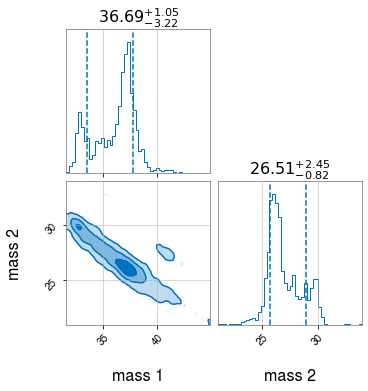

In [15]:
result_short.plot_corner(parameters=["mass_1", "mass_2"])

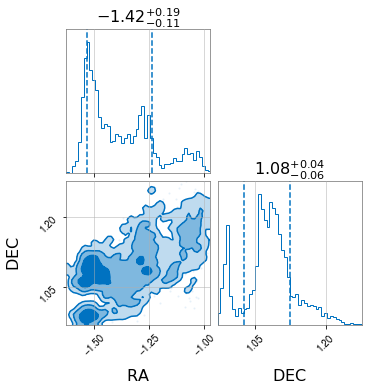

In [16]:
result_short.plot_corner(parameters=["ra", "dec"])

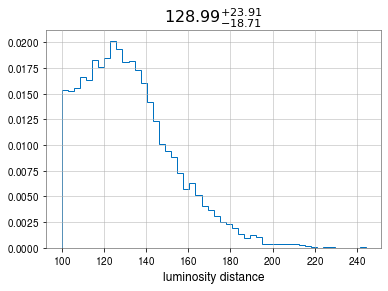

In [17]:
result_short.plot_corner(parameters=["luminosity_distance"])